# Background:

In [Part-1](https://www.kaggle.com/code/chandrimad31/credit-risk-part-1-probability-of-default-model), we built PD model (white box) which is fully explainable. While using Black-Box models like Neural Net, Gradient Boosting, Random Forest etc. explability is a challenge. We will use two packages [LIME (Local Interpretable Model-Agnostic Explanations)](https://lime-ml.readthedocs.io/en/latest/) and [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/index.html) here to work on model explainability.

For data preprocessing, we will work more or less on the same line of approach that we followed in Part-1, except for the fact, here we need to use Label Encoder to convert categorical variables to numeric.

In [1]:
# import libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.tight_layout()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

data = pd.read_csv(r'../input/loan-data-2007-2014/loan_data_2007_2014/loan_data_2007_2014.csv')

# create a new column based on the loan_status column that will be our target variable
data['bad_loan'] = np.where(data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Drop the original 'loan_status' column
data.drop(columns = ['loan_status'], inplace = True)
data.drop('Unnamed: 0', inplace=True, axis=1)

X = data.drop('bad_loan', axis = 1)
y = data['bad_loan']

#dropping irrelevant cols & cols with missing values

columns_to_drop = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                  'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee', 'desc', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m',
                  'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
                  'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m','policy_code', 'mths_since_last_delinq']
data.drop(columns=columns_to_drop, inplace=True, axis=1)

data.dropna(inplace=True)

# Removing multicollinear features 
data.drop(columns=['loan_amnt', 'revol_bal', 'funded_amnt', 'funded_amnt_inv', 'installment',  'total_pymnt_inv',  'out_prncp_inv',  'total_acc'], inplace=True)

# converting emp_length to numeric and assign NaN to zero

def emp_length_convert(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)
    
emp_length_convert(data, 'emp_length')

# converting term to numeric

def term_numeric(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))
    
term_numeric(data, 'term')

# preprocessing date cols 

def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)
    

date_columns(data, 'issue_d')
date_columns(data, 'last_pymnt_d')
date_columns(data, 'last_credit_pull_d')
date_columns(data, 'earliest_cr_line')

# converting to dataframe 
backup_data = data
preprocess_data = data

In [2]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in preprocess_data.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    preprocess_data[col] = lencoders[col].fit_transform(preprocess_data[col])

In [3]:
#seperating data into target and features
X= preprocess_data.drop(columns='bad_loan', axis=1)
y=preprocess_data['bad_loan']

In [4]:
import gc
gc.collect()

173

# Model Explainability with LIME

In [5]:
from lime.lime_tabular import LimeTabularExplainer
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [6]:
from sklearn.model_selection import train_test_split
trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
  X = data
  y = labels.values
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12345)
  pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start_time

  train_accuracy =  pipe.score(X_train, y_train)
  test_accuracy = pipe.score(X_test, y_test) 
  model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
  return model_details

models = [
          {"name": "Extra Trees", "clf": ExtraTreesClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)}, 
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)},
          {"name": "XGBoost", "clf": XGBClassifier(silent=True)},
          {"name": "CatBoost", "clf": CatBoostClassifier()}, 
          {"name": "MLP Neural Net", "clf": MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10,10,5,2), max_iter=500, random_state=42)}]

for model in models:
  model_details = train_model(model, X, y) 
  trained_models.append(model_details)

[17:11:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:11:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.114676
0:	learn: 0.5004762	total: 130ms	remaining: 2m 9s
1:	learn: 0.3493085	total: 227ms	remaining: 1m 53s
2:	learn: 0.2519825	total: 392ms	remaining: 2m 10s
3:	learn: 0.1955042	total: 561ms	remaining: 2m 19s
4:	learn: 0.1533402	total: 725ms	remaining: 2m 24s
5:	learn: 0.1294165	total: 864ms	remaining: 2m 23s
6:	learn: 0.1086802	total: 1.04s	remaining: 2m 27s
7:	le

In [7]:
from lime.lime_tabular import LimeTabularExplainer
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12345) 

def get_lime_explainer(model, data, labels):  

  cat_feat_ix = [i for i,c in enumerate(data.columns) if pd.api.types.is_categorical_dtype(data[c])]
  feat_names = list(data.columns)
  class_names = list(labels.unique())
  scaler = model["model"]["scaler"]
  data = scaler.transform(data) # scale data to reflect train time scaling
  lime_explainer = LimeTabularExplainer(data,
                                      feature_names=feat_names,
                                      class_names=class_names,
                                      categorical_features=cat_feat_ix ,
                                      mode="classification"
                                      )
  return lime_explainer

def lime_explain(explainer, data, predict_method, num_features): 
  explanation = explainer.explain_instance(data, predict_method, num_features=num_features) 
  return explanation

lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(X.columns)
test_data_index = 6
for current_model in trained_models:  
  scaler = current_model["model"]["scaler"]
  scaled_test_data = scaler.transform(X_test)
  predict_method = current_model["model"]["clf"].predict_proba 
  top_x = 10
  start_time = time.time()
  # explain first sample from test data
  lime_explainer = get_lime_explainer(current_model, X_train, y_train)
  explanation = lime_explain(lime_explainer, scaled_test_data[test_data_index], predict_method, top_x) 
  elapsed_time = time.time() - start_time 

  ex_holder = {}
  for feat_index,ex in explanation.as_map()[1] :
    ex_holder[feat_names[feat_index]] = ex
  
  lime_data_explainations.append(ex_holder) 
  actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1,-1))
  perc_pred_diff =  abs(actual_pred[0][1] - explanation.local_pred[0])   
  lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })
  lime_metrics.append({"lime class1": explanation.local_pred[0], "actual class1": actual_pred[0][1], "class_diff": round(perc_pred_diff,3), "model": current_model["name"] })

In [8]:
def setup_plot():
  plt.rcParams["axes.grid.axis"] ="y"
  plt.rcParams["axes.grid"] = True
  plt.rcParams["legend.fontsize"] = 20
  plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
  plt.rcParams["xtick.labelsize"] = 18
  plt.rcParams["ytick.labelsize"]  = 18

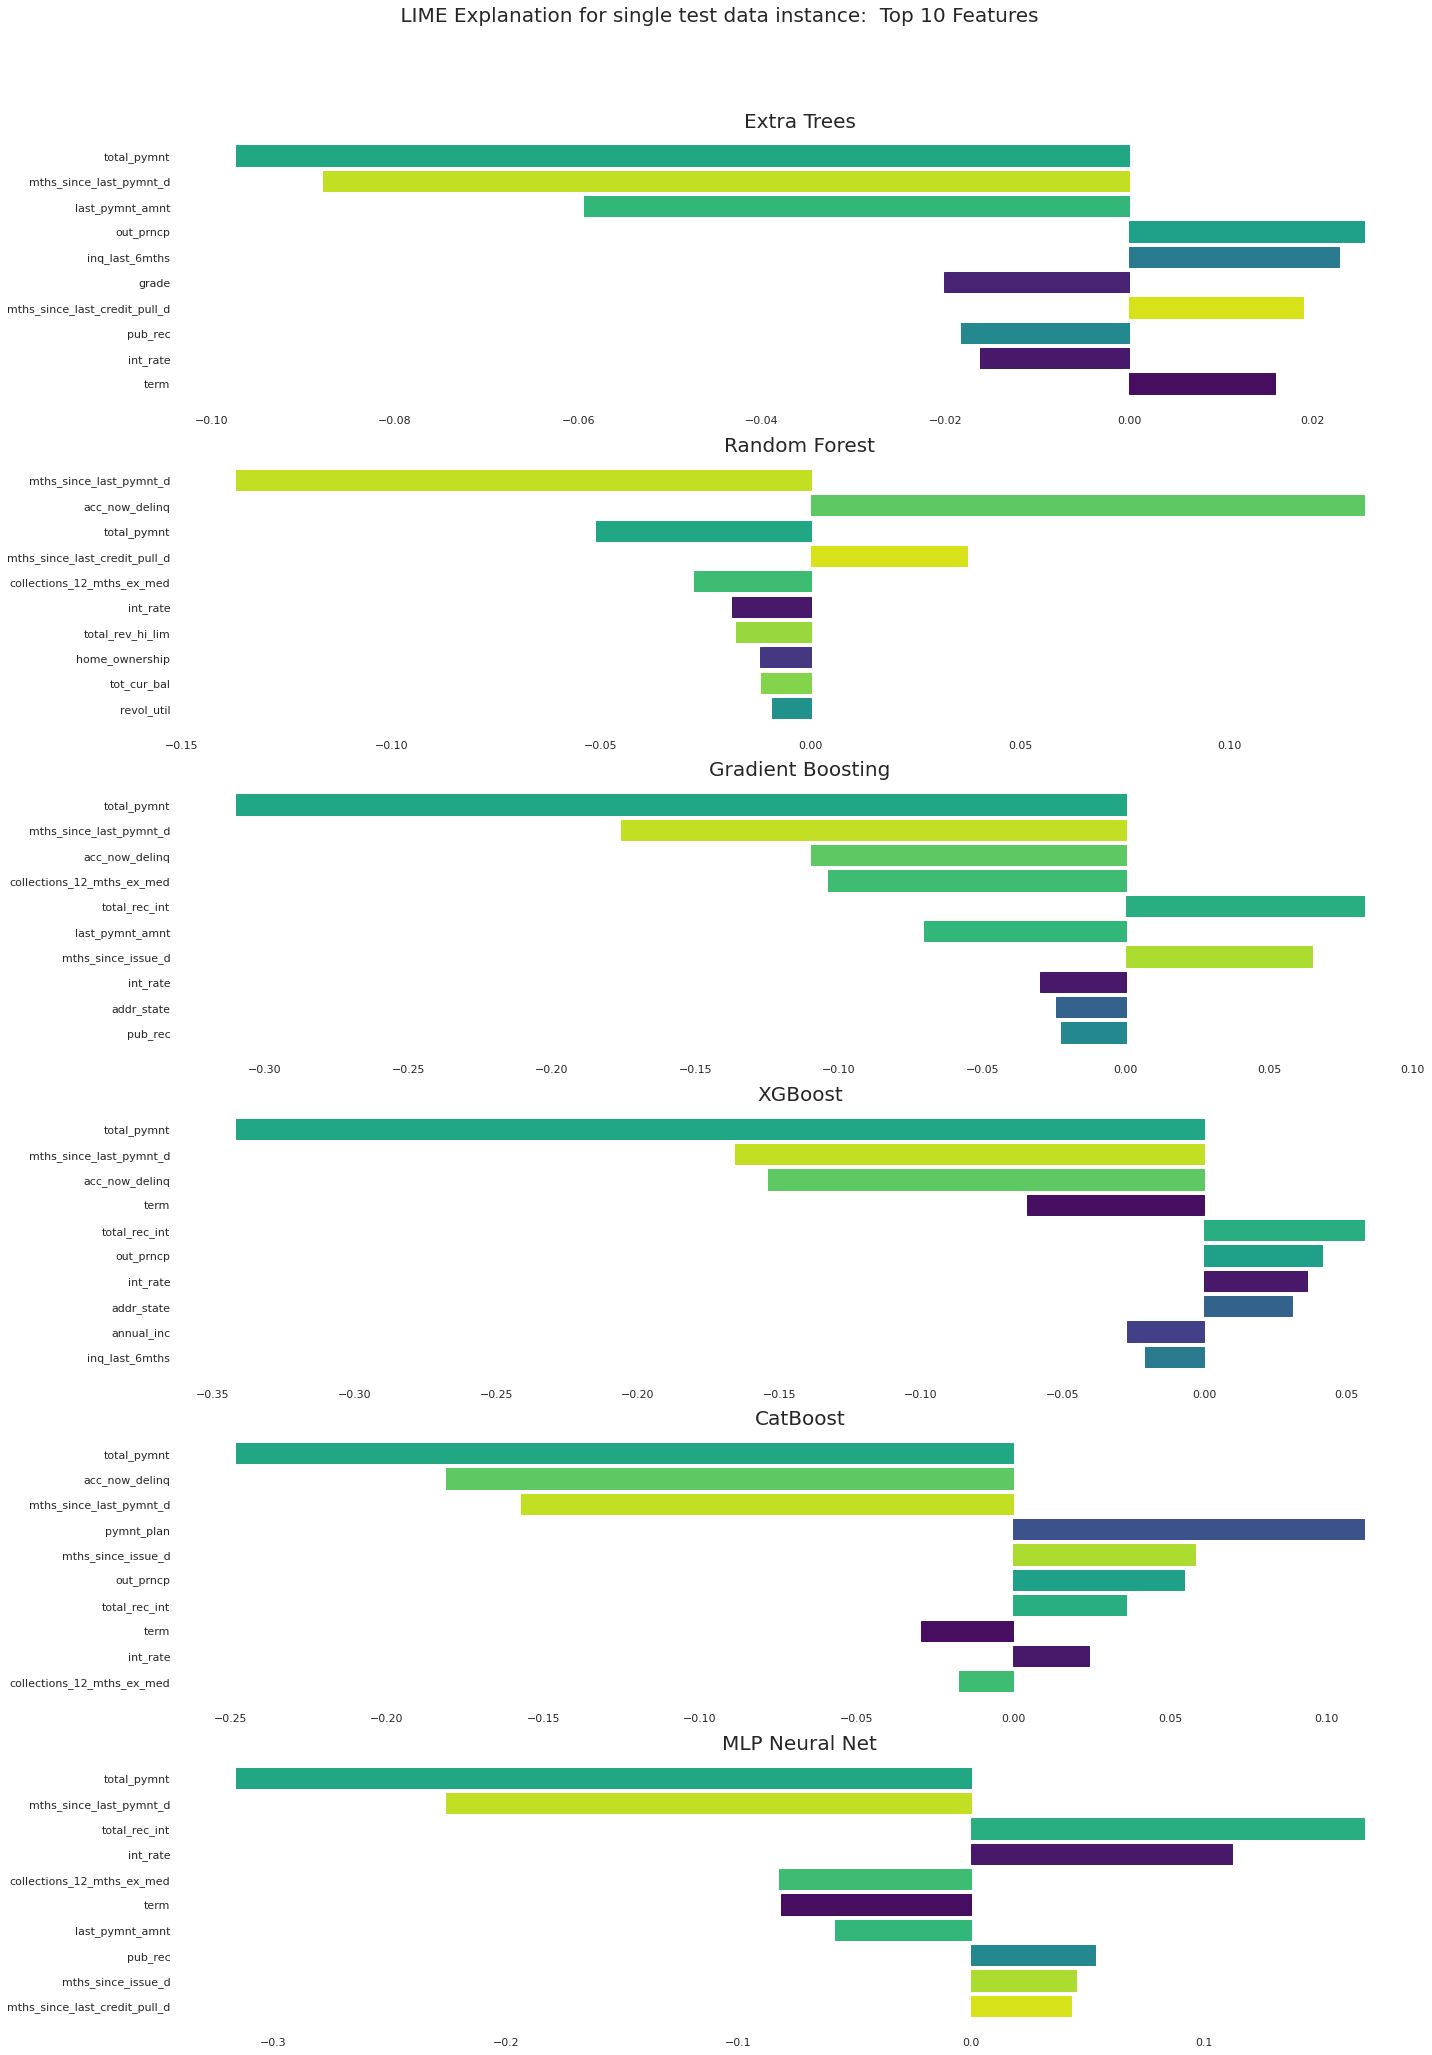

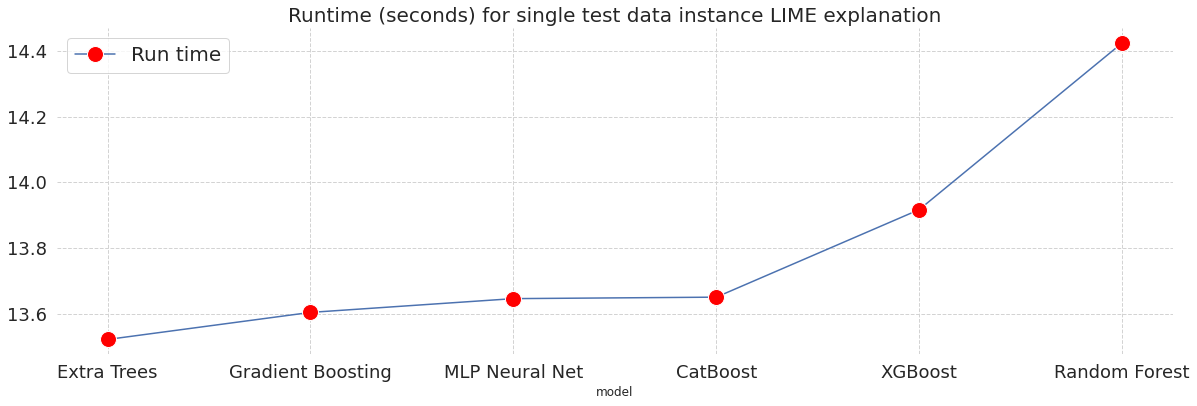

In [9]:
color_list =  sns.color_palette("viridis", len(X.columns)) 

def plot_lime_exp(fig, fig_index, exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index) 
  lime_bar = ax.barh( features, explanations ) 
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(X.columns).index(features[i])])
    plt.box(False) 
fig = plt.figure(figsize=(20,30))

# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
  fig_index = int("61" + str(i+1))
  plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle( " LIME Explanation for single test data instance:  Top " + str(top_x) + " Features", fontsize=20, fontweight="normal")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot run time for explanations
lx_df = pd.DataFrame(lime_explanation_time)
lx_df.sort_values("time", inplace=True)
setup_plot()
lx_ax = lx_df.plot(kind="line", marker="o", mfc="red", mec="white", markersize=16, x="model", title="Runtime (seconds) for single test data instance LIME explanation", figsize=(20,6))
lx_ax.title.set_size(20)
lx_ax.legend(["Run time"])
plt.box(False)

# Checking if the above Explainability derived by LIME can be Trusted or Not

We need to compare local prediction by LIME vs actual prediction for all the models to verify if the above model explainabilities are reliable or not. If there is very minimal difference between local vs actual prediction, then the model explainability by LIME (above) should be trusted, else not.

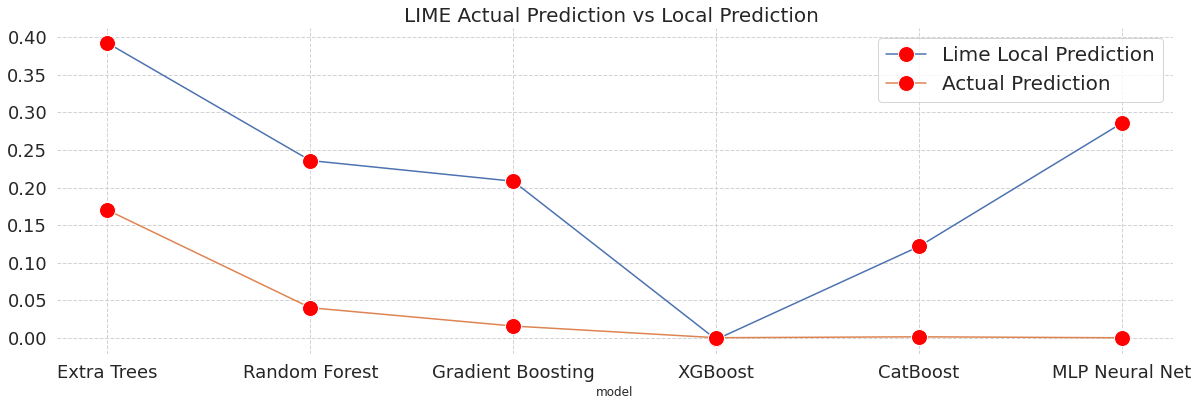

In [10]:
# Plot run time for explanations
lime_metrics_df = pd.DataFrame(lime_metrics)  
lime_metrics_df_ax = lime_metrics_df[["lime class1", "actual class1", "model"]].plot(kind="line", marker="o", mfc="red", mec="white", markersize=16, x="model", title="LIME Actual Prediction vs Local Prediction ", figsize=(20,6))
lime_metrics_df_ax.title.set_size(20)
lime_metrics_df_ax.legend(["Lime Local Prediction", "Actual Prediction"])
plt.box(False)

We observe: 
* The difference between local prediction and actual prediction is the least for XGBoost. Hence, we can trust model explainablity for XGBoost using LIME. 
* "total_pymnt", "mnths_since_last_pymnt", "term", "collections_12_mnths_ex_med", "acc_now_delinq", "annual_inc",  are the features which negatively contribute towards bad loan (i.e. positively contributes to good loan)
* "out_prncp", "total_rec_int", "int_rate", "last_pymnt_amnt" positively contribute towards bad loan

# SHAP Kernel Explainer

There is another alternative SHAP Tree Explainer which is a faster alternative. You may use that too instead of Kernel Explainer.

In [11]:
import shap
current_model = trained_models[3] # Explain the XGBoost Model
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]
scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(scaled_train_data, 1000, random_state=0) 
# use 1000 samples of train data as background data

scaled_test_data = scaler.transform(X_test) 
subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
elapsed_time = time.time() - start_time
# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", current_model["name"])
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

Kernel Explainer SHAP run time 15.063  seconds.  XGBoost
SHAP expected value [0.0938007 0.9061993]
Model mean value [0.09957783 0.9004221 ]
Model prediction for test data [[9.9992967e-01 7.0321701e-05]]


SHAP shows: 
- "mths_since_last_pymnt_d", "total_pymnt", "last_pymnt_amnt" contribute negatively towards default. 
- "out_prncp" contributes positively towards default.


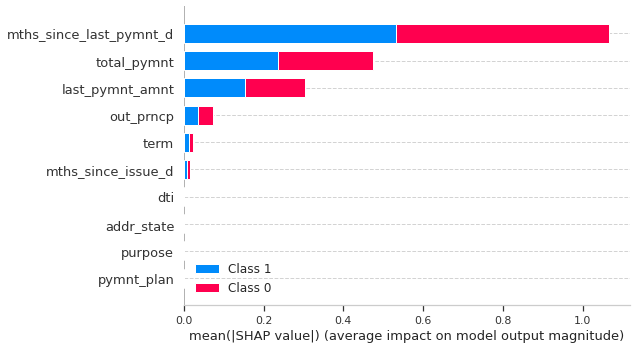

In [12]:
shap.initjs()
shap.summary_plot(shap_values, subsampled_test_data, feature_names=X_train.columns, max_display=10)

# Explain a Test Data Instance for all Models

In [13]:
import shap

def get_kernel_shap_explainer(model, background_data, train_data):  
  shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)   
  return shap_explainer 

def shap_explain(explainer, test_data): 
  shap_values = explainer.shap_values(test_data, l1_reg="aic")
  
  return shap_values

shap_data_explainations = []
shape_explanation_time = []
feat_names = list(X.columns) 
data_subsample = 500 
for current_model in trained_models:  
  scaler = current_model["model"]["scaler"]
  scaled_test_data = scaler.transform(X_test)
  scaled_train_data = scaler.transform(X_train)
  sampled_scaled_train_data = shap.sample(scaled_train_data, data_subsample) # subsample background data to make things faster
  
  start_time = time.time()
  shap_explainer  = get_kernel_shap_explainer(current_model["model"]["clf"], sampled_scaled_train_data, scaled_train_data)

  # explain first sample from test data 
  sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1,-1)
  shap_values = shap_explain(shap_explainer, sampled_scaled_test_data) 
  elapsed_time = time.time() - start_time 
  idx = np.argsort(np.abs(shap_values[1][0]))[::-1] 
  ex_holder = { feat_names[idx[i]] : shap_values[1][0][idx[i]] for i in range(top_x)} 
   
 
  shap_data_explainations.append(ex_holder) 
  shape_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

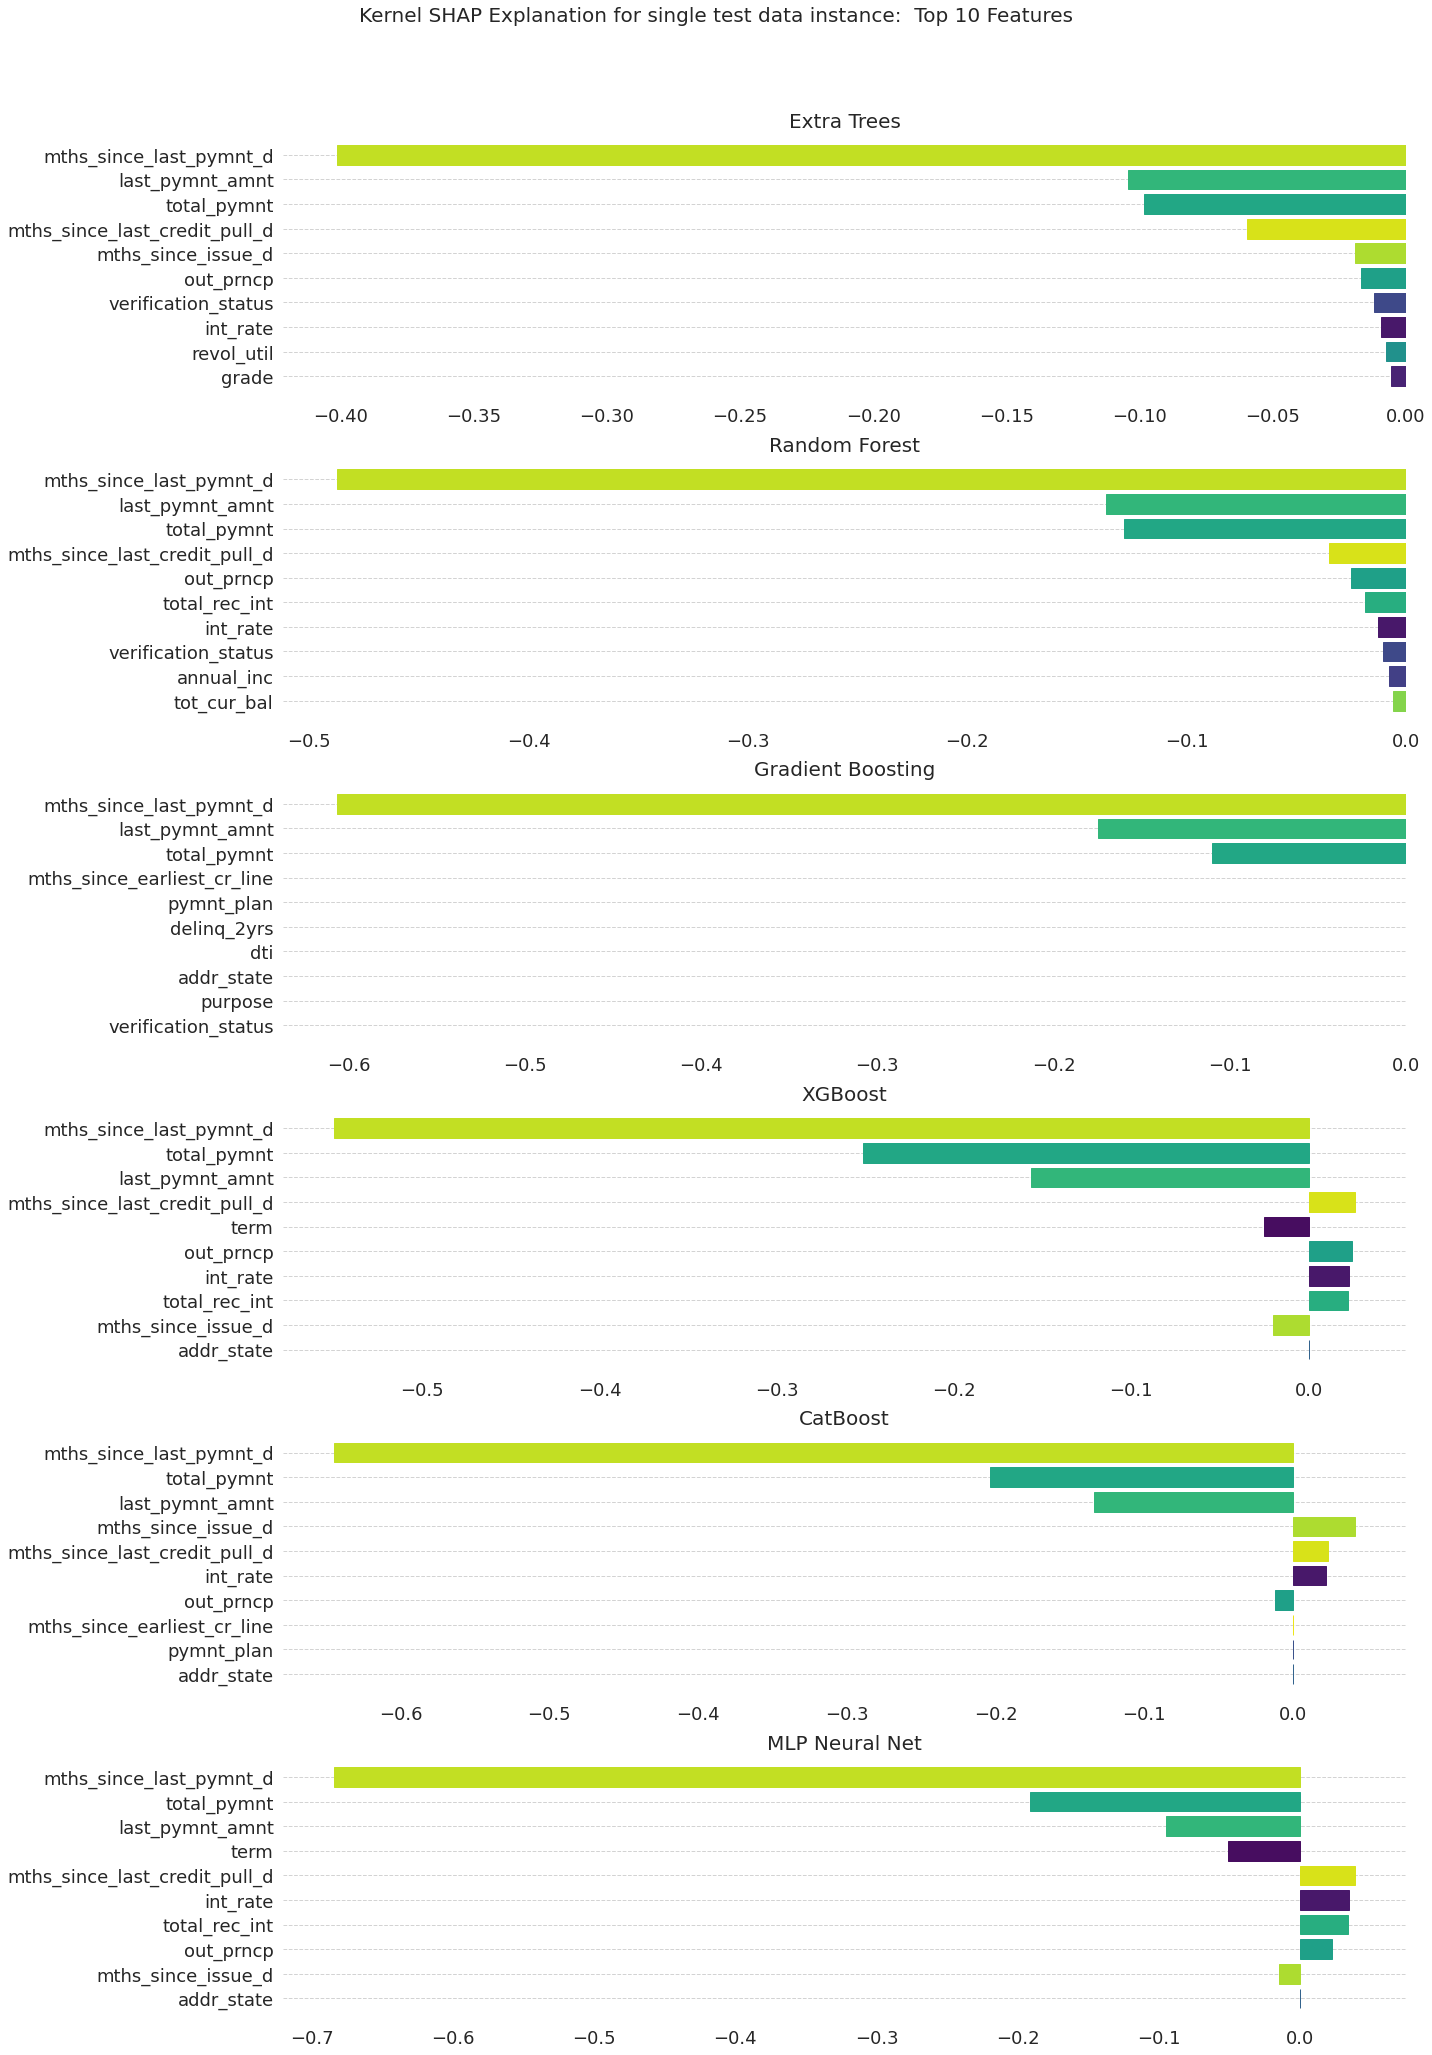

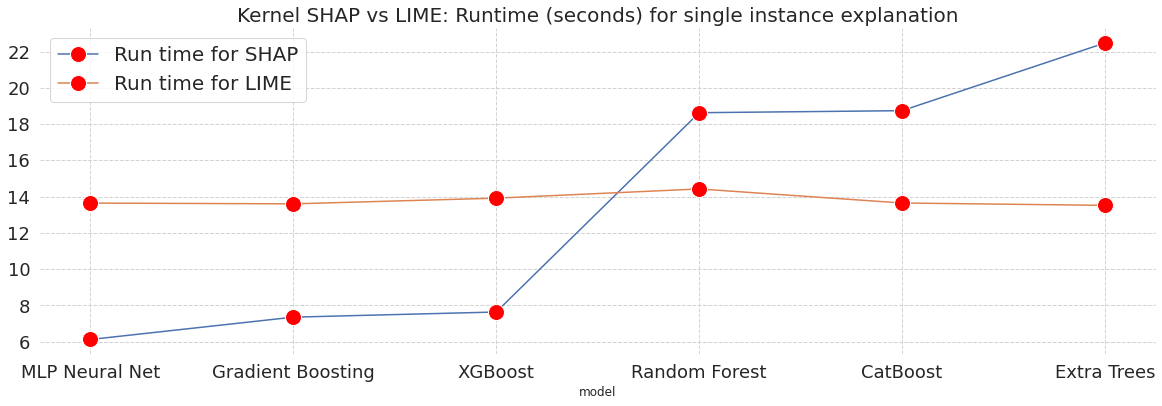

In [14]:
def plot_shap_exp(fig, fig_index, exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index) 
  lime_bar = ax.barh( features, explanations ) 
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(current_data.columns).index(features[i])])
    plt.box(False) 


# Plot SHAP explanations for a given test set item
fig = plt.figure(figsize=(20,30))
for i, dex in enumerate(shap_data_explainations):
  fig_index = int("61" + str(i+1))
  plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle( "Kernel SHAP Explanation for single test data instance:  Top " + str(top_x) + " Features", fontsize=20, fontweight="normal")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot SHAP explanation run time
shapx_df = pd.DataFrame(shape_explanation_time)
shapx_df.sort_values("time", inplace=True)

# Plot both LIME and SHAP explanation run times
m_df =  shapx_df.merge(lx_df, on="model", suffixes=("_SHAP", "_LIME")) 
m_df.head() 
mx_df_ax = m_df.plot(kind="line", marker="o", mfc="red", mec="white", markersize=16, x="model", title="Kernel SHAP vs LIME: Runtime (seconds) for single instance explanation", figsize=(20,6))
mx_df_ax.title.set_size(20)
mx_df_ax.legend(["Run time for SHAP", "Run time for LIME"])
plt.box(False)

# Acknowledgement: 

[Colab research notebooks on LIME and SHAP for model interpretablity](https://colab.research.google.com/drive/1pjPzsw_uZew-Zcz646JTkRDhF2GkPk0N#scrollTo=-YRBzUfRVTTD) 
